<a href="https://colab.research.google.com/github/karyapoormohamadie/stock_market_model/blob/main/stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [44]:
now = str(datetime.datetime.now())[:10]

df = yf.download('AMZN','2018-01-01',now,interval='1d')

[*********************100%***********************]  1 of 1 completed


In [45]:
import requests
url = 'https://www.alphavantage.co/query?function=RSI&symbol=AMZN&interval=daily&time_period=5&series_type=close&apikey=OHY3DST217RX6SV7'
response = requests.get(url)
rsi = response.json()

In [46]:
rsi_data = pd.DataFrame.from_dict(rsi['Technical Analysis: RSI'] , orient='index')
rsi_data = rsi_data[rsi_data.index >= '2018-01-01']
rsi_data['RSI'] = rsi_data['RSI'].astype(np.float64)

In [47]:
rsi_data.index = pd.to_datetime(rsi_data.index)

In [48]:
data = pd.concat([df,rsi_data],axis=1 )

In [49]:
data.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
RSI,0


In [50]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,RSI
count,1696.000000,1696.000000,1696.000000,1696.000000,1696.000000,1.696000e+03,1696.000000
mean,126.476244,127.969926,124.843645,126.434948,126.434948,7.757530e+07,53.984125
std,36.595221,36.915986,36.207324,36.537694,36.537694,3.965550e+07,19.802560
min,58.599998,59.500000,58.525501,59.450500,59.450500,1.762600e+07,4.543600
25%,92.087500,92.940001,90.924625,92.165749,92.165749,5.130900e+07,39.208200
50%,123.956749,125.715000,122.234253,124.251751,124.251751,6.642000e+07,54.476350
75%,160.606255,162.453369,158.759499,160.950371,160.950371,9.293400e+07,69.305675
max,200.089996,201.199997,199.050003,200.000000,200.000000,3.113460e+08,96.223700


<Axes: >

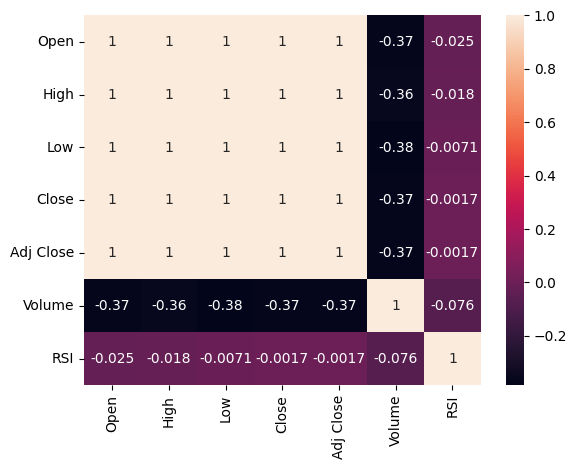

In [51]:
sns.heatmap(data.corr(),annot=True)

In [52]:
data = data.sort_index()
data

,Open,High,Low,Close,Adj Close,Volume,RSI
2018-01-02,58.599998,59.500000,58.525501,59.450500,59.450500,53890000,62.1117
2018-01-03,59.415001,60.274502,59.415001,60.209999,60.209999,62176000,72.1820
2018-01-04,60.250000,60.793499,60.233002,60.479500,60.479500,60442000,75.1156
2018-01-05,60.875500,61.457001,60.500000,61.457001,61.457001,70894000,83.1650
2018-01-08,61.799999,62.653999,61.601501,62.343498,62.343498,85590000,87.6820
...,...,...,...,...,...,...,...
2024-09-23,191.639999,194.449997,190.570007,193.880005,193.880005,36993100,83.7489
2024-09-24,194.270004,195.369995,190.130005,193.960007,193.960007,43478900,83.8885
2024-09-25,193.750000,193.949997,192.160004,192.529999,192.529999,26391100,70.3772
2024-09-26,194.309998,194.529999,189.539993,191.160004,191.160004,36334900,58.9977


<Axes: ylabel='Volume'>

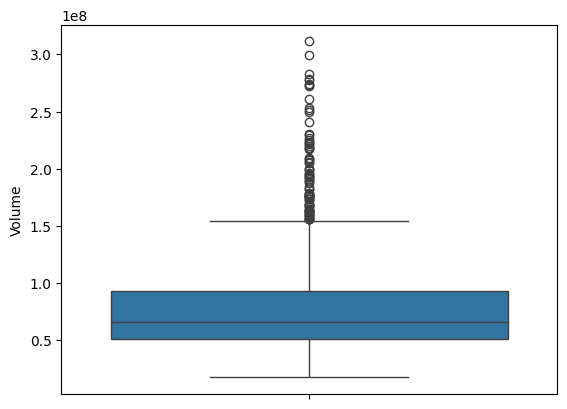

In [53]:
sns.boxplot(data.Volume)

In [54]:
import plotly.graph_objects as go

In [55]:
def tracer(Y):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=data.index,y=Y,mode='lines'))

  fig.show()

In [56]:
tracer(data['Open'])

In [57]:
tracer(data['Close'])

In [58]:
test_lengh = data[(data.index > '2023-01-01')].shape[0]
test_lengh

437

In [68]:
def create_featurs(data,feature_length):

  x=[]
  y=[]

  for i in range(len(data) - feature_length):
    x.append(data.iloc[i : i + feature_length].values)
    y.append(data['Close'].values[i + feature_length])

  x = np.array(x)
  y = np.array(y)

  return x,y



In [69]:
x , y = create_featurs(data,32)

In [70]:
x_train , x_test , y_train , y_test = x[:-test_lengh] , x[-test_lengh:] ,y[:-test_lengh] , y[-test_lengh:]

In [73]:
from sklearn.preprocessing import  MinMaxScaler

class MultiDimentionScaler():
  def __init__(self):
    self.scalers = []

  def fit_transform(self , X):
    total_dim = X.shape[2]
    for i in range(total_dim):
      Scaler = MinMaxScaler()
      X[:,:,i] = Scaler.fit_transform(X[:,:,i])
      self.scalers.append(Scaler)
    return X

  def transform(self,X):
    for i in range(X.shape[2]):
      X[:,:,i] = self.scalers[i].transform(X[:,:,i])
    return X



In [74]:
feature_scaler = MultiDimentionScaler()

x_train = feature_scaler.fit_transform(x_train)
x_test = feature_scaler.transform(x_test)


In [75]:
target_scaler = MinMaxScaler()
y_train = target_scaler.fit_transform(y_train.reshape(-1,1))
y_test = target_scaler.transform(y_test.reshape(-1,1))


In [76]:
def save(obj ,name:str):
  path = open(f'{name}.pck','wb')
  pickle.dump(obj,path)
  path.close

def load(obj,name):
  path = open(f'{name}.pck','rb')
  lo = pickle.load(path)
  return lo

In [77]:
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau

checkpoint = ModelCheckpoint('/content/drive/MyDrive/checkpoint/model.weights.h5',monitor = 'val_loss',mode='min',save_best_only=True,save_weights_only=True)
learn_rate_reducer = ReduceLROnPlateau(factor = 0.25,patience=3,min_lr=0.0001)

In [78]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf


model = Sequential()

model.add(layers.Input((32,7)))

model.add(layers.Bidirectional(layers.LSTM(512,return_sequences=True,recurrent_dropout=0.1)))
model.add(layers.LSTM(256,recurrent_dropout=0.1))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64,activation='elu'))
model.add(layers.Dense(32,activation='elu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(32,activation='elu'))
model.add(layers.Dense(1,activation='linear'))




In [79]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),loss='mse')

In [ ]:
model.fit(x_train,y_train
          ,epochs=40,
          verbose=1,
          batch_size=1,
          validation_data=(x_test,y_test),
          callbacks=[checkpoint,learn_rate_reducer],
          shuffle=False)

Epoch 1/40
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 121s 95ms/step - loss: 0.0060 - val_loss: 0.5818 - learning_rate: 0.0050
Epoch 2/40
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 138s 94ms/step - loss: 0.0041 - val_loss: 0.6316 - learning_rate: 0.0050
Epoch 3/40
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 116s 95ms/step - loss: 0.0039 - val_loss: 0.6659 - learning_rate: 0.0050
Epoch 4/40
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 116s 94ms/step - loss: 0.0038 - val_loss: 0.5852 - learning_rate: 0.0050
Epoch 5/40
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 144s 96ms/step - loss: 0.0091 - val_loss: 0.3183 - learning_rate: 0.0012
Epoch 6/40
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 118s 96ms/step - loss: 0.0107 - val_loss: 0.2273 - learning_rate: 0.0012
Epoch 7/40
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 142s 96ms/step - loss: 0.0081 - val_loss: 0.1566 - learning_rate: 0.0012
Epoch 8/40
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 143s 97ms/step - loss: 0.0071 - val_loss: 0.1192 - learning_rate: 0.0012
Epoch 9/40
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 118s 96ms/step - loss: 0.0062 - val_lo

In [76]:
model_load_weights('/content/drive/MyDrive/checkpoint/model.weights.h5')
prediction = model.predict(x_test)

In [77]:
prediction = target_scaler.inverse_transform(prediction)
actual = target_scaler.inverse_transform(y_test)

NameError: name 'prediction' is not defined

In [ ]:
prediction.shape,prediction[0]

In [ ]:
prediction = np.squeeze(prediction,axis=1)
actual = np.squeeze(actual,axis=1)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index[-test_lengh:],y=prediction , mode='lines',name='predicted'))
fig.add_trace(go.Scatter(x=data.index[-test_lengh:],y=actual , mode='lines',name='actual'))

fig.show()